### Importing modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import itertools
import pickle
import os

from IPython.display import clear_output

from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from tensorflow.keras import regularizers

import tensorflow_addons as tfa

from tensorflow import keras
from keras.applications.vgg19 import VGG19
from keras.applications import ResNet50V2
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

c:\Users\GeorgiosSavvidis\env311_m\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\GeorgiosSavvidis\env311_m\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you 

### Constants

In [18]:
# DIRECTORIES

DATASET = []
DATASET.append("dataset2/Brain Tumor Data Set/Brain Tumor Data Set_pp100")

DATASET_PP = []
TRAIN_PATH = []
TEST_PATH = []
CLASS_LABELS = []
NUM_OF_CLASSES = []

for ii, ds in enumerate(DATASET):
    DATASET_PP.append(ds)
    TRAIN_PATH.append(ds + "/Train")
    TEST_PATH.append(ds + "/Test")
    CLASS_LABELS.append([filename for filename in os.listdir(TRAIN_PATH[ii]) if os.path.isdir(os.path.join(TRAIN_PATH[ii], filename))])
    
    NUM_OF_CLASSES.append(len(CLASS_LABELS[ii]))


# OTHER
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [19]:
try_r_seeds = [42,123]
try_optimizers = ['adam']
try_ds = [0]
try_kernels = [3]
try_layers = [4]
try_folds = [5]

In [20]:
combos = list(itertools.product(try_r_seeds, try_optimizers, try_ds, try_kernels, try_layers, try_folds))

# Now all_combinations contains all possible combinations of the lists
print(f"Number of Hyperparameter combinations to by : {len(combos)}")

Number of Hyperparameter combinations to by : 2


## Function Definitions

### Data Augmentation

In [5]:
def data_augmentation(r, s):
    # here we will define just the ImageDataGenrator
    # with 0 as the validation split to keep all the images of the traindataset
    # as currently in the train directory
    # we will split this to train-validation sets within the KFold loop

    random.seed(r)

    trn_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=s,
        rotation_range=20,          # randomly rotate the images by 20 degrees
        zoom_range=0.2,             # randomly zoom in/out on the images by 20%
        horizontal_flip=True,       # randomly flip the images horizontally
        vertical_flip=False,        # don't flip the images vertically
        width_shift_range=0.1,      # randomly shift the images horizontally by 10%
        height_shift_range=0.1,     # randomly shift the images vertically by 10%
        shear_range=0.1,            # apply random shear transformations
        fill_mode='nearest'         # fill in any empty pixels with the nearest available pixel
        )
    
    return trn_datagen

In [6]:
def test_data(tst_path, idx, img_size, batch_size):
    # and we can also define the test generator

    tst_datagen = ImageDataGenerator(rescale=1./255)


    tst_generator = tst_datagen.flow_from_directory(tst_path[idx],
                                                    target_size=img_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)
    return tst_generator

In [7]:
def plot_train_history(h, save2f = ''):
    
    hm=['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score']
    e = len(h.history['loss'])

    # Plot metric values for the current seed
    plt.figure(figsize=(12, 6))

    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.plot(range(1, e+1), h.history[hm[i]], label=hm[i])
        plt.title(hm[i])
        plt.xticks([])
        
        
    plt.tight_layout()
    
    if save2f != '':
        plt.savefig("outputs/" + save2f + ".png")

    plt.show()

In [8]:
def string_to_int(my_seed):
    
    if isinstance(my_seed, str):
        ascii_values = 0
        for char in my_seed:
            ascii_values += ord(char)
        return int(ascii_values)
    else:
        return my_seed

# Custom CNN

### Model definition

In [9]:
def create_custom_cnn(num_layers, model_optimizer, k, imsize, n_cl, show_summary=False):
    # num_layers        : Number of layers,
    # k                 : kernel size = (k, k)

    tf.keras.backend.clear_session()
    
    if num_layers < 3 or num_layers > 5:
        raise ValueError("Number of layers must be between 3 and 5.")

    m = Sequential()
    
    m.add(Conv2D(32, (k, k), activation='relu', input_shape = imsize+(3,)))
    m.add(MaxPooling2D((2, 2)))

    for layer_idx in np.arange(2,num_layers+1,1):
        num_filters = 2**(4+layer_idx)
        m.add(Conv2D(num_filters, (k, k), activation='relu'))
        m.add(MaxPooling2D((2, 2)))

    m.add(Flatten())

    # Add fully connected layers
    m.add(Dense(256, activation='relu'))
    m.add(Dropout(0.3))
    m.add(Dense(n_cl, activation='softmax'))

    #plot_model(m, show_shapes=True, show_layer_names=True)             # doesn't work locally

    m.compile(optimizer=model_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy',
              tf.keras.metrics.Precision(),
              tf.keras.metrics.Recall(),
              tf.keras.metrics.AUC(),
              tfa.metrics.F1Score(num_classes = n_cl, average='macro')])
    
    if show_summary:
        m.summary()

    return m

In [11]:
# show an example of a model summary for 2 classes
create_custom_cnn(3, 'adam', 3, IMG_SIZE, 2, show_summary=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

### Model training for different combos

In [22]:
cwd = os.getcwd()
cwd = cwd.replace("\\","/")

test_datagen = ImageDataGenerator(rescale=1./255);

results_df = pd.DataFrame(columns=['Seed', 'Optimizer', 'Dataset', 'kernel size', 'Layers', 'Folds', 
                                   'history',
                                   'elapsed time',
                                   'test_loss',
                                   'test_accuracy',
                                   'test_precision',
                                   'test_recall',
                                   'test_auc',
                                   'test_f1_score'])

for ii, combo in enumerate(combos):

    this_r_seed, this_optimizer, this_ds, this_kernel, this_layer, this_folds  = combo

    start_time = time.time()

    random.seed(this_r_seed)
        
    print("\n\n################################################################################")
    print(f"combination : {ii+1} of {len(combos)}")
    print(f"Seed : {this_r_seed}, Optimizer : {this_optimizer}, {os.path.basename(DATASET[this_ds])}, kernel = {this_kernel}x{this_kernel},  Layers = {this_layer}, folds = {this_folds}")
                  
    print(f"\n-----------------------------------------------------------------")

    train_datagen = data_augmentation(this_r_seed, 0)

    print("Train Generator")
    train_generator = train_datagen.flow_from_directory(TRAIN_PATH[this_ds],
                                                        target_size=IMG_SIZE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        shuffle=True,
                                                        subset='training'
                                                        )
    
    # val_generator = train_datagen.flow_from_directory(TRAIN_PATH[this_ds],
    #                                                 target_size=IMG_SIZE,
    #                                                 batch_size=BATCH_SIZE,
    #                                                 class_mode='categorical',
    #                                                 shuffle=False,
    #                                                 subset='validation'
    #                                                 )
    
    print("Test geenrator")
    test_generator = test_datagen.flow_from_directory(TEST_PATH[this_ds],
                                                target_size=IMG_SIZE,
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                shuffle=False)

    es = EarlyStopping(monitor="val_accuracy", 
                mode="max",
                restore_best_weights=True,
                patience=6)
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=2, min_lr=0.0000001)

    print(f"\n----------------------------------------------------------------- Training")
        
    int_seed = string_to_int(this_r_seed)
    np.random.seed(string_to_int(int_seed))
    tf.random.set_seed(int_seed)

    model = create_custom_cnn(this_layer, this_optimizer, this_kernel, IMG_SIZE, NUM_OF_CLASSES[this_ds])

    kf = StratifiedKFold(n_splits=this_folds, shuffle=True, random_state=this_r_seed)
    
    hist = []

    for fold, (train_indices, val_indices) in enumerate(kf.split(train_generator.filepaths, train_generator.classes)):
        print("\n- - - - - - -")
        print(f"Fold {fold+1} / {this_folds}")
        
        # Split the data into training and validation sets for this fold
        X_train, X_val = np.array(train_generator.filepaths)[train_indices], np.array(train_generator.filepaths)[val_indices]
        y_train, y_val = np.array(train_generator.classes)[train_indices], np.array(train_generator.classes)[val_indices]

        # X_train = [train_generator.directory + "/"+ s.replace('\\', '/') for s in X_train]
            
        #    os.path.join(TRAIN_PATH[ii], filename)
        X_train = [os.path.join(os.getcwd(), s) for s in X_train ]

        
        img_df_train = pd.DataFrame({'filename': X_train, 
                                     'class': list(y_train.astype('str'))})

        fold_train_generator = train_datagen.flow_from_dataframe(img_df_train, 
                                                                 directory=None,  
                                                                 x_col='filename', 
                                                                 y_col='class',
                                                                 target_size=IMG_SIZE,
                                                                 class_mode = 'categorical',
                                                                 batch_size = BATCH_SIZE
                                                                 )
        
        img_df_val = pd.DataFrame({'filename': X_val, 
                                   'class': list(y_val.astype('str'))})
                
        fold_val_generator = train_datagen.flow_from_dataframe(img_df_val, 
                                                               directory=None,  
                                                               x_col='filename', 
                                                               y_col='class',
                                                               target_size=IMG_SIZE,
                                                               class_mode = 'categorical',
                                                               batch_size = BATCH_SIZE
                                                               )
        
        hist_fold = model.fit(fold_train_generator,
                        epochs=30,
                        validation_data=fold_val_generator,
                        callbacks=[es, reduce_lr]
                        )

        hist.append(hist_fold.history)

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"\n----------------------------------------------------------------- Evaluation")

    this_result = model.evaluate(test_generator);
    
    new_row = [this_r_seed, this_optimizer, os.path.basename(DATASET[this_ds]), this_kernel, this_layer, this_folds] + [hist, int(elapsed_time+0.5)] + this_result


    results_df.loc[len(results_df)] = new_row
    results_df.reset_index(drop=True, inplace=True)

    #clear_output()



################################################################################
combination : 1 of 2
Seed : 42, Optimizer : adam, Brain Tumor Data Set_pp100, kernel = 3x3,  Layers = 4, folds = 5

-----------------------------------------------------------------
Train Generator
Found 3244 images belonging to 2 classes.
Test geenrator
Found 812 images belonging to 2 classes.

----------------------------------------------------------------- Training

- - - - - - -
Fold 1 / 5
Found 2595 validated image filenames belonging to 2 classes.
Found 649 validated image filenames belonging to 2 classes.
Epoch 1/30
82/82 [==============================] - 135s 2s/step - loss: 0.6996 - accuracy: 0.5522 - precision: 0.5522 - recall: 0.5522 - auc: 0.5537 - f1_score: 0.4302 - val_loss: 0.6841 - val_accuracy: 0.5686 - val_precision: 0.5686 - val_recall: 0.5686 - val_auc: 0.5560 - val_f1_score: 0.3625 - lr: 0.0010
Epoch 2/30
82/82 [==============================] - 180s 2s/step - loss: 0.6646 - accura

# Explore Results

In [26]:
results_df

,Seed,Optimizer,Dataset,kernel size,Layers,Folds,history,elapsed time,test_loss,test_accuracy,test_precision,test_recall,test_auc,test_f1_score
0,42,adam,Brain Tumor Data Set_pp100,3,4,5,"[{'loss': [0.6995593905448914, 0.6645825505256...",9913,0.113550,0.963054,0.963054,0.963054,0.991688,0.962113
1,123,adam,Brain Tumor Data Set_pp100,3,4,5,"[{'loss': [0.7104091644287109, 0.6797532439231...",6751,0.172038,0.940887,0.940887,0.940887,0.981224,0.939428


### Average test metrics

In [37]:
df = results_df.groupby('Optimizer')[['test_accuracy', 'test_precision', 'test_recall', 'test_auc', 'test_f1_score']].mean().reset_index()
df

,Optimizer,test_accuracy,test_precision,test_recall,test_auc,test_f1_score
0,adam,0.95197,0.95197,0.95197,0.986456,0.95077


## Plot the training history of a specific seed

In [85]:
def plot_seed_history(df, splot):
    sh = df.loc[df['Seed'] == splot, 'history'].values[0]

    plot_keys=[['loss', 'val_loss'],
            ['accuracy', 'val_accuracy'],
            ['precision', 'val_precision'],
            ['recall', 'val_recall'],
            ['auc', 'val_auc'],
            ['f1_score', 'val_f1_score']
            ]


    for plot_key in plot_keys:

        mh_all_fld =[[], []]

        for fld,fld_h in enumerate(sh):
            mh_in_fld = fld_h[plot_key[0]]
            mh_all_fld[0] = mh_all_fld[0] + mh_in_fld
            
            mh_in_fld = fld_h[plot_key[1]]
            mh_all_fld[1] = mh_all_fld[1] + mh_in_fld
            
        e = len(mh_all_fld[0])

        plt.figure(figsize=(12, 6))

        plt.plot(range(1, e+1), mh_all_fld[0], label=plot_key[0])
        plt.plot(range(1, e+1), mh_all_fld[1], label=plot_key[1])

        plt.title(f"{plot_key[0]} - {plot_key[1]}")

        plt.xticks([])
        plt.legend()
        plt.show()

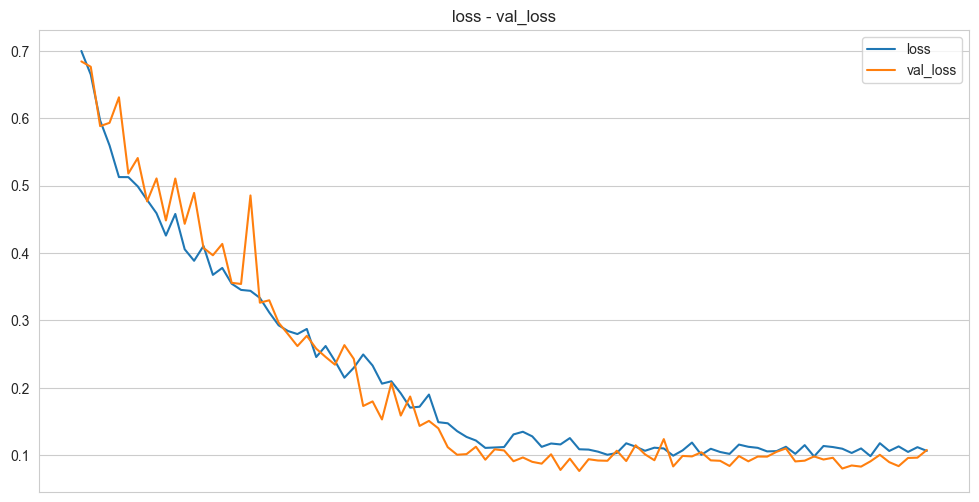

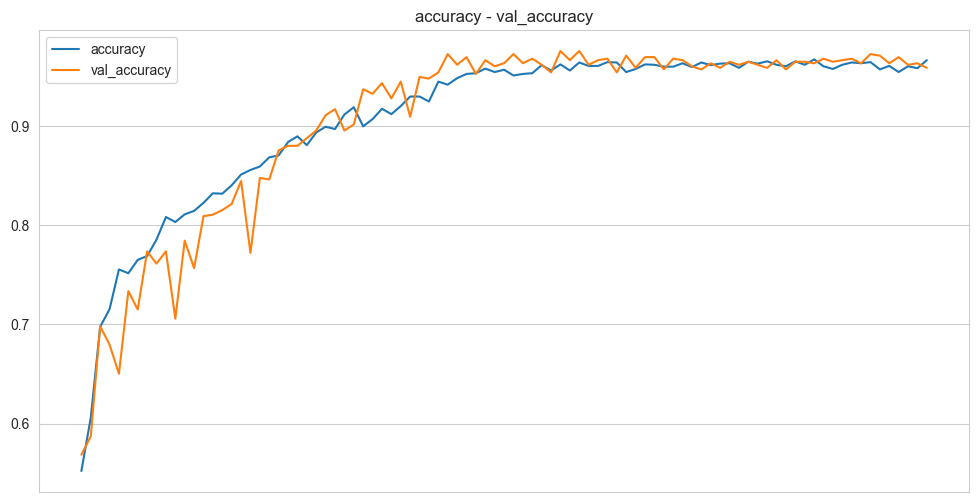

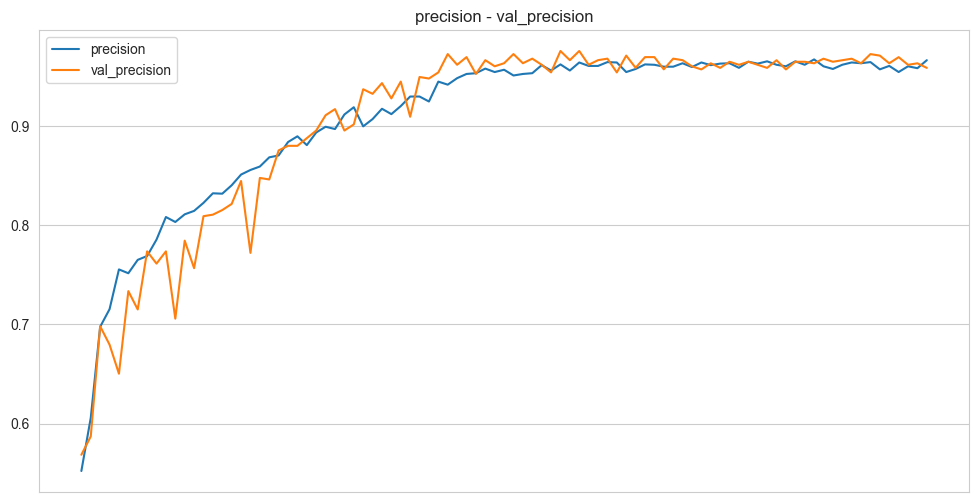

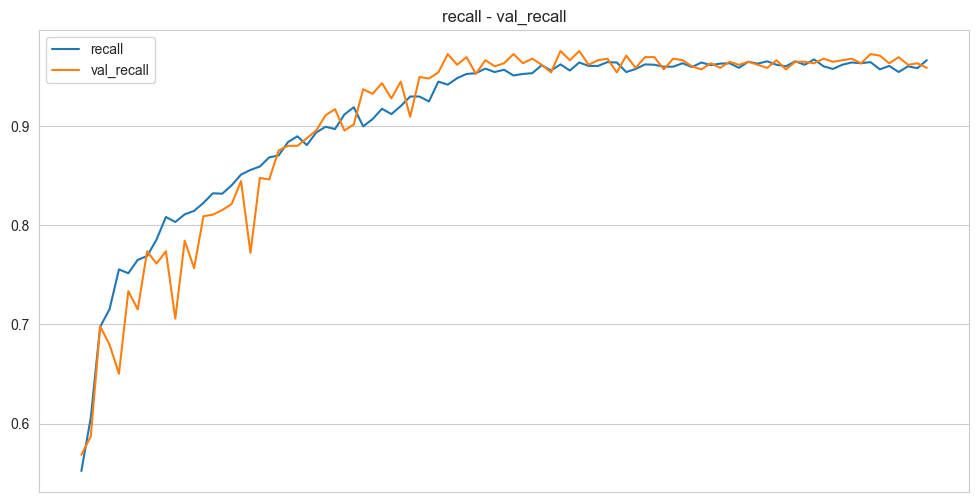

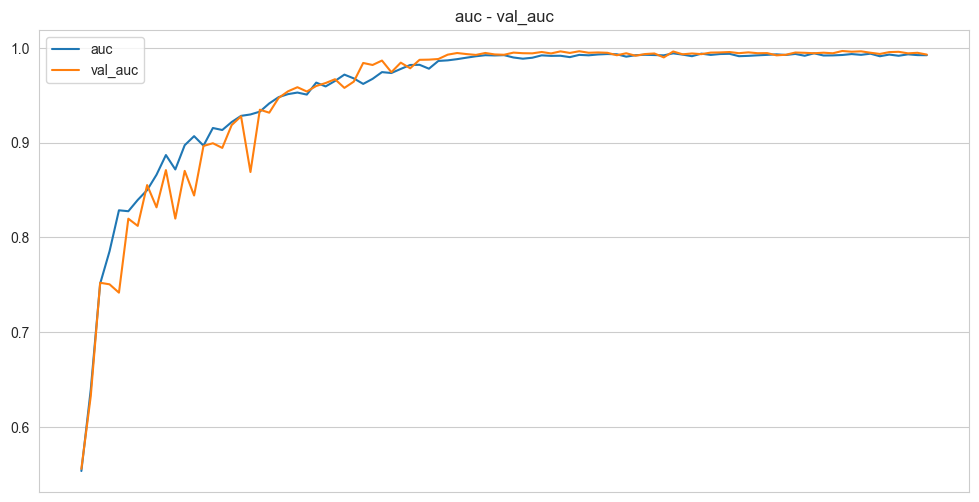

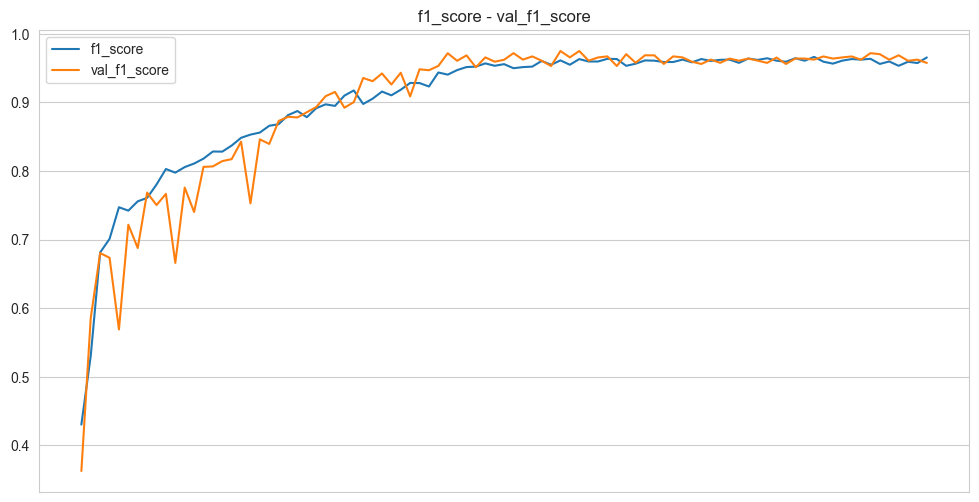

In [86]:
splot = 42                # Seed training history to plot

plot_seed_history(results_df, splot)

# END